<a href="https://colab.research.google.com/github/aashu-0/llm-from-scratch/blob/main/05pretrained_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow>=2.15.0  tqdm>=4.66
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00


In [2]:
# getting scripts from github
!git clone https://github.com/aashu-0/llm-from-scratch.git
%cd llm-from-scratch/llm_book_notes

Cloning into 'llm-from-scratch'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 101 (delta 54), reused 70 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 138.44 KiB | 6.02 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/llm-from-scratch/llm_book_notes


In [3]:
import sys
sys.path.append('/content/llm-from-scratch/llm_book_notes')

downloading `gpt_download.py` from github

In [4]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
urllib.request.urlretrieve(url, "gpt_download.py")

('gpt_download.py', <http.client.HTTPMessage at 0x7d85c9bee690>)

In [5]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size='124M',
                                          models_dir='gpt2')

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 30.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.20MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 185kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:36<00:00, 5.17MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 7.29MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 540kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 678kiB/s]


In [6]:
print('settings:', settings)
print('Parameter dictionary keys:', params.keys())

settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


`settings`: dictionary to store llm architecture settings (aka config)

`params`: dictionary which stores weights of different layers

In [7]:

print('Weights of token embedding layer:\n' , params['wte'])
print('Shape: \n',params['wte'].shape)

Weights of token embedding layer:
 [[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Shape: 
 (50257, 768)


In [8]:
# config dict for different model sizes

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
    }

In [9]:
CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 1024,
    'emb_dim': 768,
    'n_heads':12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': True
}

In [10]:
# gpt-2 small

model_name = 'gpt2-small (124M)'
CONFIG = CONFIG_124M.copy()
CONFIG.update(model_configs[model_name])

In [11]:
import torch
# utility function to check two tensors or array are of same dim
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f'Shape mismatch: {left.shape} != {right.shape}')

  return torch.nn.Parameter(torch.tensor(right))

#### Loading openai weights into our GPT model code

In [12]:
import numpy as np
def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

  for b in range(len(params['blocks'])):

    # query, key, value weight
    q_w, k_w, v_w = np.split(
        (params['blocks'][b]['attn']['c_attn'])['w'],
        3, axis=-1)
    gpt.trf_blocks[b].attn.W_query.weight = assign(gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
    gpt.trf_blocks[b].attn.W_key.weight = assign(gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
    gpt.trf_blocks[b].attn.W_value.weight = assign(gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

    # query, key, value bias
    q_b, k_b, v_b = np.split(
        (params['blocks'][b]['attn']['c_attn'])['b'],
        3, axis=-1)
    gpt.trf_blocks[b].attn.W_query.bias = assign(gpt.trf_blocks[b].attn.W_query.bias, q_b)
    gpt.trf_blocks[b].attn.W_key.bias = assign(gpt.trf_blocks[b].attn.W_key.bias, k_b)
    gpt.trf_blocks[b].attn.W_value.bias = assign(gpt.trf_blocks[b].attn.W_value.bias, v_b)

    # out_proj weight and bias
    gpt.trf_blocks[b].attn.out_proj.weight = assign(gpt.trf_blocks[b].attn.out_proj.weight, params['blocks'][b]['attn']['c_proj']['w'].T)
    gpt.trf_blocks[b].attn.out_proj.bias = assign(gpt.trf_blocks[b].attn.out_proj.bias, params['blocks'][b]['attn']['c_proj']['b'])

    # feedforward layer
    gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params['blocks'][b]['mlp']['c_fc']['w'].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params['blocks'][b]['mlp']['c_fc']['b'])

    gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params['blocks'][b]['mlp']['c_proj']['w'].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params['blocks'][b]['mlp']['c_proj']['b'])

    # layer norm1
    gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params['blocks'][b]['ln_1']['g'])
    gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params['blocks'][b]['ln_1']['b'])

    #layer norm2
    gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params['blocks'][b]['ln_2']['g'])
    gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params['blocks'][b]['ln_2']['b'])

  #layer norm3
  gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])

  # out head
  gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
from GPT import GPTModel

gpt = GPTModel(CONFIG)
gpt.eval()
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [15]:
import tiktoken
import torch.nn.functional as F

from GPT import generate
from utilities import text_to_token_ids, token_ids_to_text
tokenizer = tiktoken.get_encoding('gpt2')

In [16]:
torch.manual_seed(123)
token_ids = generate(
    model= gpt,
    idx = text_to_token_ids('Every Effort moves you', tokenizer).to(device),
    max_new_tokens = 25,
    context_size = CONFIG['context_length'],
    top_k = 40,
    temp= 1.4
)

print(f'Output text:\n {token_ids_to_text(token_ids, tokenizer)}')

Output text:
 Every Effort moves you as far as the target can go until the end of your turn. This effect cannot be prevented. As you move you gain


`The Verdict` dataset

In [17]:
# loading the-verdict.txt file
file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

text_data[:50]

'I HAD always thought Jack Gisburn rather a cheap g'

In [28]:
split = 0.8
split_idx =  int(split*len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

len(train_data), len(val_data)

(16383, 4096)

In [47]:
# dataloader

from CustomDatasetDataloader import create_dataloders_v1
torch.manual_seed(123)

train_dataloader = create_dataloders_v1(
    txt=train_data,
    batch_size= 1,
    max_length= CONFIG['context_length'],
    stride = CONFIG['context_length'],
    drop_last= True,
    shuffle = True,
    num_workers = 0)

val_dataloader = create_dataloders_v1(
    txt=val_data,
    batch_size= 1,
    max_length= CONFIG['context_length'],
    stride = CONFIG['context_length'],
    drop_last= False,
    shuffle = False,
    num_workers = 0)

In [48]:
for x, y in train_dataloader:
  print(x.shape)
  print(y.shape)

torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 1024])


In [49]:
for x, y in val_dataloader:
  print(x.shape)
  print(y.shape)

torch.Size([1, 1024])
torch.Size([1, 1024])


Epoch: 1 | Step: 000000
Train Loss: 0.137 | Val Loss: 8.177
Every effort moves you forward, but it's not till after that event that the _rose Dubarry_ drawing-rooms, the speaking-tubes, the dress-closets, the trouser-presses--all the complex simplifications of the millionaire's
Epoch: 2 | Step: 000005
Train Loss: 0.043 | Val Loss: 7.911
Every effort moves you toward a neutral surface, you can always get near enough to see it. But it's the height of his glory, you can always get near enough to see it. The height of his glory--that was the height of his glory, at that
Epoch: 3 | Step: 000010
Train Loss: 0.038 | Val Loss: 7.425
Every effort moves you can just manage to face it--it's the last he painted, you know, so it's been reared in the hot-house of their adulation. The fact should be set down in extenuation. What struck me now was that
Epoch: 4 | Step: 000015
Train Loss: 0.017 | Val Loss: 7.675
Every effort moves you forward, but I don't think of that, Mr. Rickham--the _rose Dubarry_ 

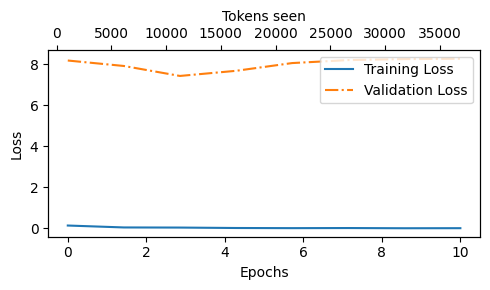

In [50]:
from utilities import train_model_simple, plot_losses
import torch.nn.functional as F

torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.0004, weight_decay= 0.1)

epochs = 10

train_losses, val_losses, token_seen = train_model_simple(
    gpt, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=epochs, eval_freq=5, eval_iter= 5,
    start_context= 'Every effort moves you', tokenizer=tokenizer)

epochs_tensor = torch.linspace(0, epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

over model is overfitting